# Deglinting comparison for a Sentinel-2 granule

This notebook demonstrates the different deglinting methods available witin the sungc module:

* Hedley et al., 2005 (correlation approach)
* Cox and Munk 1954 (statistical/geometry approach)
* NIR/SWIR subtraction (e.g. Dierssen et al., 2015)

In [1]:
import numpy
import matplotlib.pyplot as plt
import datacube
from sungc import deglint, visualise
from sungc import rasterio_funcs as rf

In [2]:
dc = datacube.Datacube(env="water-atcor", config="/g/data/r78/dea-atmospheric-correction-over-water/datacube.conf")

The `ga_s2am_aard_3` product is comprised of the following sub-products:

* lmbskyg `lambertian sky glint corrected`
* oa `observation attributes`

In the same way that the `ga_ls8c_ard_3` product which contains the following sub-products:

* nbar `nadir corrected brdf adjusted reflectance
* nbart `nadir corrected brdf adjusted reflectance terrain illumination correction
* oa `observation attributes`

In [3]:
sub_product = "lmbskyg"
bands = [f"{sub_product}_{band}" for band in ["coastal_aerosol", "blue", "green", "red", "red_edge_1", "red_edge_2", "nir_2"]]
measurements = bands.copy().extend(["oa_satellite_view", "oa_solar_zenith", "oa_relative_azimuth"])
query = {
    "product": "ga_s2am_aard_2",
    "region_code": "55HBT",
    "time": ("2017-04-17", "2017-04-19"),
    "measurements": measurements,
    "output_crs": "epsg:3577",
    "resolution": (-20, 20)
}

In [4]:
data = dc.load(**query)
data

<xarray.Dataset>
Dimensions:                     (time: 1, x: 2579, y: 5473)
Coordinates:
  * time                        (time) datetime64[ns] 2017-04-18T00:13:02.923916
  * y                           (y) float64 -4.202e+06 -4.202e+06 ... -4.312e+06
  * x                           (x) float64 1.082e+06 1.082e+06 ... 1.134e+06
    spatial_ref                 int32 3577
Data variables:
    lmbskyg_coastal_aerosol     (time, y, x) int16 -999 -999 -999 ... -999 -999
    lmbskyg_blue                (time, y, x) int16 -999 -999 -999 ... -999 -999
    lmbskyg_green               (time, y, x) int16 -999 -999 -999 ... -999 -999
    lmbskyg_red                 (time, y, x) int16 -999 -999 -999 ... -999 -999
    lmbskyg_red_edge_1          (time, y, x) int16 -999 -999 -999 ... -999 -999
    lmbskyg_red_edge_2          (time, y, x) int16 -999 -999 -999 ... -999 -999
    lmbskyg_red_edge_3          (time, y, x) int16 -999 -999 -999 ... -999 -999
    lmbskyg_nir_1               (time, y, x) int16 -999 -999 -999 ... -999 -999
    lmbskyg_nir_2               (time, y, x) int16 -999 -999 -999 ... -999 -999
    lmbskyg_swir_2              (time, y, x) int16 -999 -999 -999 ... -999 -999
    lmbskyg_swir_3              (time, y, x) int16 -999 -999 -999 ... -999 -999
    oa_fmask                    (time, y, x) uint8 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    oa_combined_terrain_shadow  (time, y, x) uint8 1 1 1 1 1 ... 255 255 255 255
    oa_azimuthal_exiting        (time, y, x) float32 48.42946 -95.17903 ... nan
    oa_azimuthal_incident       (time, y, x) float32 108.61692 ... nan
    oa_exiting_angle            (time, y, x) float32 14.287402 ... nan
    oa_incident_angle           (time, y, x) float32 58.21405 58.06685 ... nan
    oa_relative_azimuth         (time, y, x) float32 62.38568 62.38636 ... nan
    oa_relative_slope           (time, y, x) float32 60.18746 61.13952 ... nan
    oa_satellite_azimuth        (time, y, x) float32 100.9937 100.99368 ... nan
    oa_satellite_view           (time, y, x) float32 13.374724 ... nan
    oa_solar_azimuth            (time, y, x) float32 38.608017 38.607323 ... nan
    oa_solar_zenith             (time, y, x) float32 57.38039 57.38007 ... nan
    oa_time_delta               (time, y, x) float32 -0.09845947 ... nan
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref

In [5]:
g = deglint.GlintCorrX(data)

Specify the bands to be used in creating a quicklook RGB

In [6]:
rgb_bands = bands[1:4][::-1]
print(rgb_bands)

['lmbskyg_red', 'lmbskyg_green', 'lmbskyg_blue']


## Hedley 2005
The Hedley method requires a Region Of Interest to be selected (or provided) that contains both deep water and sun glint affected pixels.

In [7]:
%matplotlib
hedley_xarr = g.hedley_2005(
    rgb_varlist=rgb_bands,
    vis_bands=bands[0:-1],
    corr_band=f"{sub_product}_nir_2",
)

Using matplotlib backend: Qt5Agg


## Cox and Munk 1954

In [8]:
cm_xarr = g.cox_munk(
    vis_bands=bands[0:-1],
    wind_speed=5,
    vzen_band="oa_satellite_view",
    szen_band="oa_solar_zenith",
    razi_band="oa_relative_azimuth",
)

/g/data/up71/modules/sunglint-cor/0.1/lib/python3.6/site-packages/sungc/algorithms.py:339: RuntimeWarning: invalid value encountered in greater
  phi_raz[phi_raz > 180.0] -= 360.0


## Glint subtraction

In [9]:
subtract_xarr = g.glint_subtraction(
    vis_bands=bands[0:-1],
    corr_band=f"{sub_product}_nir_2",
)

## Comparison

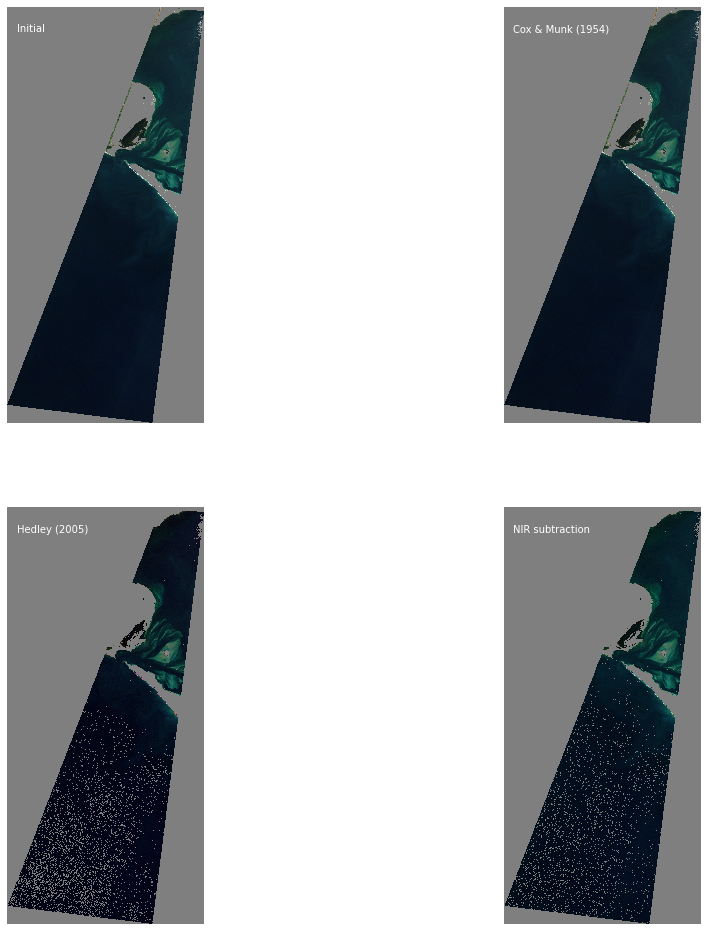

In [10]:
%matplotlib inline
annotate_list = [
        "Initial",
        "Cox & Munk (1954)",
        "Hedley (2005)",
        "NIR subtraction",
    ]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 13))
for t in range(data.dims["time"]):
    master_ds = [
        data.isel(time=t),
        cm_xarr.isel(time=t),
        hedley_xarr.isel(time=t),
        subtract_xarr.isel(time=t),
    ]

    for i, ds_i in enumerate(master_ds):
        rix, cix = numpy.unravel_index(i, (2, 2))

        refl_im = numpy.array(
            [
                ds_i.variables[rgb_bands[0]].values,  # R
                ds_i.variables[rgb_bands[1]].values,  # G
                ds_i.variables[rgb_bands[2]].values,  # B
            ],
            order="C"
        )

        rgb_im = visualise.seadas_style_rgb(refl_im, [0, 1, 2], 10000.0, True)
            
        axes[rix, cix].imshow(rgb_im, interpolation="None")
        axes[rix, cix].axis("off")
        axes[rix, cix].annotate(
            annotate_list[i],
            xy=(0.05, 0.94),
            xycoords="axes fraction",
            fontsize=10,
            color="w",
        )

    fig.subplots_adjust(
        left=0.01, right=0.99, bottom=0.01, top=0.99, wspace=0.01
    )